In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
def plot_sudoku(n):
    # Simple plotting statement that ingests a 9x9 array (n), and plots a sudoku-style grid around it.
    plt.figure()
    for y in range(10):
        plt.plot([-0.05,9.05],[y,y],color='black',linewidth=1)
        
    for y in range(0,10,3):
        plt.plot([-0.05,9.05],[y,y],color='black',linewidth=3)
            
    for x in range(10):
        plt.plot([x,x],[-0.05,9.05],color='black',linewidth=1)
    
    for x in range(0,10,3):
        plt.plot([x,x],[-0.05,9.05],color='black',linewidth=3)

    plt.axis('image')
    plt.axis('off') # drop the axes, they're not important here

    for x in range(9):
        for y in range(9):
            foo=n[8-y][x] # need to reverse the y-direction for plotting
            if foo > 0: # ignore the zeros
                T=str(foo)
                plt.text(x+0.3,y+0.2,T,fontsize=20)

    plt.show()

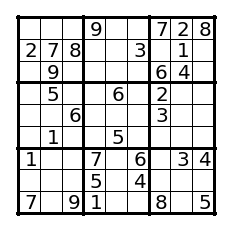

In [3]:
sudoku_hard=np.array([[0,0,0,9,0,0,7,2,8],
                      [2,7,8,0,0,3,0,1,0],
                      [0,9,0,0,0,0,6,4,0],
                      [0,5,0,0,6,0,2,0,0],
                      [0,0,6,0,0,0,3,0,0],
                      [0,1,0,0,5,0,0,0,0],
                      [1,0,0,7,0,6,0,3,4],
                      [0,0,0,5,0,4,0,0,0],
                      [7,0,9,1,0,0,8,0,5]])
plot_sudoku(sudoku_hard)

In [4]:
def check(i,k,n):
    #determines number of unique elements in each row (k=1) or column (k!=1)
    nums=np.arange(9)+1
    nu=0
    for j in range(9):
        if k==1:
            i1 = n[i][j]-1
        else:
            i1 = n[j][i]-1

        if i1==-1: # Quick check that there are no zeros
            return -1
        
        if nums[i1]!=0:
            nu+=1
            nums[i1]=0
  
    return nu

In [5]:
def checksq(isq, jsq, n):
    # determines number of unique elements in square isq, jsq
    nums=np.arange(9)+1
    nu = 0
    i0 = isq*3
    j0 = jsq*3
    for i in range(3):
        for j in range(3):
            i1 = n[i0+i][j0+j] - 1

            if i1==-1: # Quick check that there are no zeros
                return -1
        
            if nums[i1]!=0:
                nu+=1
                nums[i1]=0
                
    return nu

In [6]:
def calc_energy(n):
    # computes the "energy" of the input grid configuration
    sum = 0
    for i in range(9):
        sum += check(i,1,n) + check(i,2,n)
    
    for i in range(3):
        for j in range(3):
            sum += checksq(i,j,n)

    return 243 - sum

In [7]:
n = sudoku_hard
mask = n>0

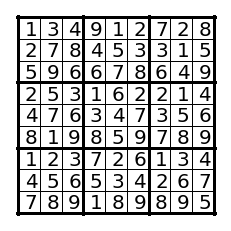

In [8]:
# Assign the remaining integers to open cells so that each block contains all integers once only.
for ib in range(3):
    for jb in range(3):

        nums=np.arange(9)+1  #{1,2...8,9}
        for i in range(3):
            for j in range(3):
                i1 = ib*3 + i
                j1 = jb*3 + j

                if n[i1][j1]!=0:
                    ix = n[i1][j1]
                    # replace the already used number with 0
                    nums[ix-1]=0

        # Now we have an array that contains the unused numbers.
        # So we populate using that array.
        iy = -1
        num1=np.zeros(sum(nums>0))
        for k in range(9):
            if nums[k]!=0:
                iy+=1
                num1[iy] = nums[k]

        kk = 0
        for i in range(3):
            for j in range(3):
                i1 = ib*3 + i
                j1 = jb*3 + j
                if(n[i1][j1]==0):
                    n[i1][j1] = num1[kk]
                    kk+=1

plot_sudoku(n)

In [9]:
# What is the energy of our starting position?
e_prev = calc_energy(n)
print('The system Energy of the initial configuration is:', e_prev) 

temp = 2.0 # starting temperature
ntrial = 100000 # number of trials we are going to run
thermo= 0.9 # thermostat for the temperature when it's too hot
reanneal=1000 # how often do we apply the thermostat?

The system Energy of the initial configuration is: 48


0 0.18887560283756186 48 51
5000 0.15233451446920723 27 29
10000 0.041310625117916513 10 12
15000 0.004531984856175492 6 8
20000 0.00010737518133552024 2 4
25000 1.89802059279624e-07 2 4
Solution found after 26022 steps


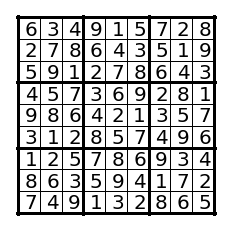


Execution time:  7.572725296020508


In [10]:
start = time.time()

for ll in range(ntrial):

    # at each step pick at random a block and two moveable elements in the block
    ib,jb = 3*np.random.randint(3,size=2)

    i1,j1 = np.random.randint(3,size=2)
    while mask[ib+i1][jb+j1]:
        i1,j1 = np.random.randint(3,size=2)

    i2,j2 = np.random.randint(3,size=2)
    while mask[ib+i2][jb+j2] or (i1==i2 and j1==j2):
        i2,j2 = np.random.randint(3,size=2)

    # swap the movable elements and compute the energy of the trial configuration
    propose_n=n.copy()
    propose_n[ib+i1][jb+j1] = n[ib+i2][jb+j2]
    propose_n[ib+i2][jb+j2] = n[ib+i1][jb+j1]

    # calculate the proposal system energy
    e_new = calc_energy(propose_n)
    deltaE = e_prev - e_new

    # Check the SA criterion
    if e_new < e_prev:
        e_prev = e_new
        n = propose_n
    else:
        if np.random.rand() < np.exp( float(deltaE)/temp):
            e_prev = e_new
            n = propose_n

    # stop computing if the solution is found
    if e_prev==0:
        break

    if(ll % reanneal) == 0:
        temp=temp*thermo
        if temp<0.1:
            temp=0.5
            
    # is the code still running properly...?
    if(ll % 5000) == 0:
        print(ll,np.exp( float(deltaE)/temp),e_prev,e_new) 

if e_prev==0:
    print("Solution found after", ll, "steps") 
    plot_sudoku(n)
    
end = time.time()
print("\nExecution time: ", end - start)